<a href="https://colab.research.google.com/github/Lucas-Monteiro-Henriques/Implement_VISIONTS/blob/main/MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importei MAE do Facebook

In [2]:
import numpy as np
import pandas as pd
import sys
import os
import subprocess
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from skimage.transform import resize
import urllib.request


import torch
import timm
from timm.models.vision_transformer import PatchEmbed, Block
np.float = float

import matplotlib.pyplot as plt
from PIL import Image

In [3]:
repo_dir = 'mae'
repo_url = 'https://github.com/facebookresearch/mae.git'

if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    if not os.path.exists('mae'):
        !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    if not os.path.exists(repo_dir):
        print(f'Cloned in : {repo_dir}')
        subprocess.run(['git', 'clone', repo_url], check=True)
    else:
        print(f'Repository already exists in {repo_dir}')

Repository already exists in mae


In [4]:
if os.path.exists('pytorch_image_models'):
    pass
else:
    !git clone https://github.com/huggingface/pytorch-image-models.git
    os.rename('pytorch-image-models', 'pytorch_image_models') #renomeia a pasta porque dá conflito nos imports


In [5]:
# from pytorch_image_models.timm.models.vision_transformer import PatchEmbed, Block

In [6]:
mae_path = os.path.abspath("mae")
if mae_path not in sys.path:
    sys.path.insert(0, mae_path)

from models_mae import mae_vit_base_patch16

In [7]:
model = mae_vit_base_patch16()

Implementação do Algoritmo de transformação das séries temporais 1D para 2D

In [8]:
df = pd.read_csv("https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTm1.csv")


serie = df["OT"].values[:66000]

acf_vals = acf(serie, nlags=min(500, len(serie)//2), fft=True)

lags = np.arange(1, len(acf_vals))
acf_sem_lag0 = acf_vals[1:]
peaks, _ = find_peaks(acf_sem_lag0, height=0.1)
P = 96

if len(peaks) == 0:
    P = 1
else:
    P = peaks[0] + 1

print(f"Periodicidade estimada: {P}")

L = (len(serie) // P) * P
serie_cortada = serie[:L]


matriz_2d = serie_cortada.reshape(P, L // P)
print("Matriz 2D:\n", matriz_2d)

Periodicidade estimada: 88
Matriz 2D:
 [[30.53100014 30.45999908 30.03800011 ... 34.04800034 33.55599976
  33.8370018 ]
 [33.27399826 32.14899826 32.7820015  ... 34.47000122 33.48500061
  33.69599915]
 [34.04800034 35.80699921 37.2140007  ... 41.50500107 40.52000046
  41.08300018]
 ...
 [ 9.42599964  9.42599964  9.21500015 ... 10.97399998 11.04399967
  11.32600021]
 [11.32600021 11.18500042 11.04399967 ... 11.39599991 11.39599991
  11.04399967]
 [11.18500042 11.39599991 11.11499977 ...  7.45699978  7.59700012
   7.73799992]]


Normalization do Iraw


In [9]:
import numpy as np
from statistics import mean
desvio_padrao = np.std(matriz_2d)
print(desvio_padrao)
mean  = np.mean(matriz_2d)
print(mean)

8.734794254719139
13.545737099749573


In [10]:
r = 0.4
Inorm = r * (matriz_2d - mean)/ desvio_padrao
print(Inorm)

[[ 0.77782086  0.77456945  0.75524449 ...  0.9388779   0.91634729
   0.92921546]
 [ 0.90343335  0.85191525  0.88090292 ...  0.95820295  0.91309597
   0.92275841]
 [ 0.9388779   1.01942926  1.0838613  ...  1.2803628   1.23525581
   1.26103774]
 ...
 [-0.18865871 -0.18865871 -0.19832119 ... -0.11776979 -0.11456423
  -0.10165033]
 [-0.10165033 -0.10810726 -0.11456423 ... -0.09844478 -0.09844478
  -0.11456423]
 [-0.10810726 -0.09844478 -0.11131286 ... -0.27882682 -0.27241567
  -0.26595874]]


Esse é o algorimo do Alignment, mas não foi testado, pois o MAE do Facebook precisa ser alterado na parte da mascara


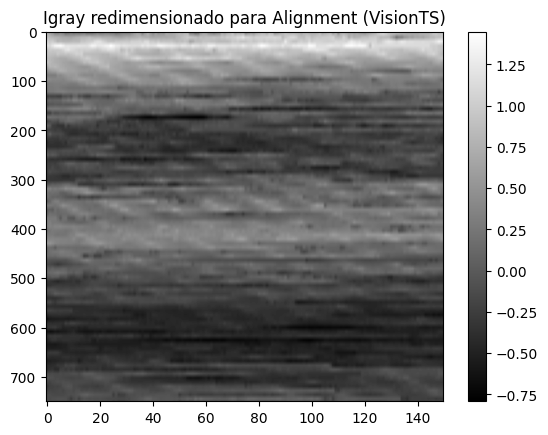

Shape original Inorm: (88, 750)
Shape Igray: (88, 750, 3)
Shape Igray_resized: (750, 150)
Shape Igray_resized_3ch: (750, 150, 3)


In [11]:
L = 96
H = 96
c = 0.4
S = 1
N = max(Inorm.shape)

# Etapa 1: Render Igray (imagem 3 canais iguais)
Igray = np.stack([Inorm] * 3, axis=-1)

# Etapa 2: Alignment
n = int(np.floor(c * N * L / (L + H)))  # número de patches visíveis na horizontal
target_shape = (N * S, n * S)           # shape final da imagem após resize

# Resize Igray (mantendo apenas 1 canal para simplificar o MAE)
Igray_resized = resize(Inorm, target_shape, order=1, mode='reflect', anti_aliasing=False)

# Converter para imagem 3 canais (opcional, dependendo do input do MAE)
Igray_resized_3ch = np.stack([Igray_resized] * 3, axis=-1)

# Visualização
plt.imshow(Igray_resized, cmap='gray', aspect='auto')
plt.title("Igray redimensionado para Alignment (VisionTS)")
plt.colorbar()
plt.show()

# Print das formas para verificação
print("Shape original Inorm:", Inorm.shape)
print("Shape Igray:", Igray.shape)
print("Shape Igray_resized:", Igray_resized.shape)
print("Shape Igray_resized_3ch:", Igray_resized_3ch.shape)


Funções do MAE

Vizulização da imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


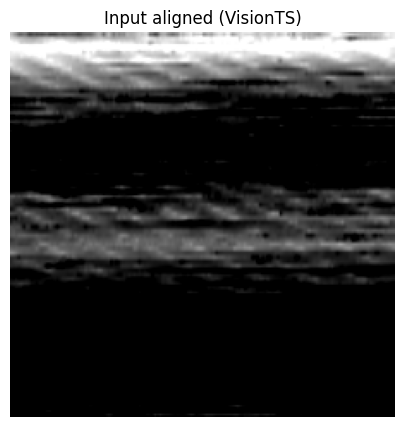

In [12]:
# Suponha que você já tem:
# Igray_resized_3ch com shape (29, 8, 3) — imagem com 3 canais e normalizada (VisionTS-style)

# Etapa 1: Redimensionar para 224 x 224 (como esperado pelo MAE)
img = resize(Igray_resized_3ch, (224, 224), order=1, mode='reflect', anti_aliasing=False)

# Etapa 2: Visualização opcional (sem normalizar com ImageNet)
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(img)
plt.title("Input aligned (VisionTS)")
plt.axis('off')
plt.show()

# Se for usar a função run_one_image, ela espera um tensor com valores normalizados já
# Portanto você pode usar:
img = torch.tensor(img, dtype=torch.float32)


Download dos pesos de Modelo


In [13]:
# MAE com decoder
if False:
    !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth

if True:
    url = 'https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth'
    dest = 'mae_visualize_vit_base.pth'

    if not os.path.exists(dest):
        print('Downloading MAE with decoder...')
        urllib.request.urlretrieve(url, dest)
    else:
        pass


In [14]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    from models_mae import mae_vit_base_patch16
    model = mae_vit_base_patch16()

    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image_from_aligned_image(Igray_resized_3ch, model, L=96, H=96, c=0.4):
    """
    Igray_resized_3ch: imagem com 3 canais (já alinhada), shape (H, W, 3), valores já normalizados
    model: modelo MAE do repo da Meta (Vit-base etc)
    L, H, c: hiperparâmetros do VisionTS
    """
    # 1. Redimensionar para 224x224 (como esperado pelo MAE)
    img = resize(Igray_resized_3ch, (224, 224), order=1, mode='reflect', anti_aliasing=False)
    x = torch.tensor(img, dtype=torch.float32).unsqueeze(0)       # [1, H, W, C]
    if False:
        x = torch.einsum('nhwc->nchw', x).cuda()                      # [1, 3, 224, 224]
    if True:
        x = torch.einsum('nhwc->nchw', x).to(device)

    # 2. Criar máscara estruturada: lado direito mascarado
    patch_size = model.patch_embed.patch_size[0]         # geralmente 16
    num_patches_row = x.shape[2] // patch_size           # 224 / 16 = 14
    num_patches = num_patches_row ** 2                   # 14 x 14 = 196

    N = num_patches_row
    n = int(np.floor(c * N * L / (L + H)))                # número de colunas visíveis

    # 0 = visível (esquerda), 1 = mascarado (direita)
    mask = torch.zeros(N*N, device=x.device)

    for row in range(N):
        for col in range(N):
            idx = row * N + col            # ROW-MAJOR (alinha com ViT)
            mask[idx] = 1.0 if col >= N - n else 0.0   # mascara colunas da direita

    mask = mask.unsqueeze(0)  # [1, N*N]
    print(mask.view(N, N)) # [1, num_patches]
   # 90º anti-horário
    print(mask.view(N, N))
    mask = mask.reshape(1, N * N) 
    
    # 3. Forward com máscara estruturada
    # 3. Forward com máscara estruturada
    # 3. Forward com máscara estruturada
    with torch.no_grad():
        if False:
            loss, y, _ = model(x.float(), mask=mask)         # usamos mask diretamente
        if True:
            loss, y, _ = model(x.float())
        y = model.unpatchify(y)                          # [1, 3, H, W]
        if False:
            y = torch.einsum('nchw->nhwc', y).cpu().numpy()
        if True:
            y = torch.einsum('nchw->nhwc', y).cpu()

        mask_recon = mask.unsqueeze(-1).repeat(1, 1, patch_size ** 2 * 3)
        mask_recon = model.unpatchify(mask_recon)
        mask_recon = torch.einsum('nchw->nhwc', mask_recon).cpu()

    x_vis = x.cpu()
    x_vis = torch.einsum('nchw->nhwc', x_vis)

    im_masked = x_vis * (1 - mask_recon)
    im_paste = x_vis * (1 - mask_recon) + y * mask_recon



    # 4. Visualização
    plt.rcParams['figure.figsize'] = [24, 6]
    plt.subplot(1, 4, 1); show_image(x_vis[0], "original")
    plt.subplot(1, 4, 2); show_image(im_masked[0], "structured mask")
    plt.subplot(1, 4, 3); show_image(y[0], "reconstruction")
    plt.subplot(1, 4, 4); show_image(im_paste[0], "reconstruction + visible")
    plt.show()

    return y[0], im_paste[0]  # retorno da imagem reconstruída (H, W, 3)

In [15]:
# Carrega o modelo base

from models_mae import mae_vit_base_patch16

chkpt_dir = 'mae_visualize_vit_base.pth'
model = mae_vit_base_patch16()
checkpoint = torch.load(chkpt_dir, map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

# Enviar para GPU
model.eval()
# model.cuda()

<All keys matched successfully>


MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=768, out_features=512, bias=

MAE with pixel reconstruction:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.,

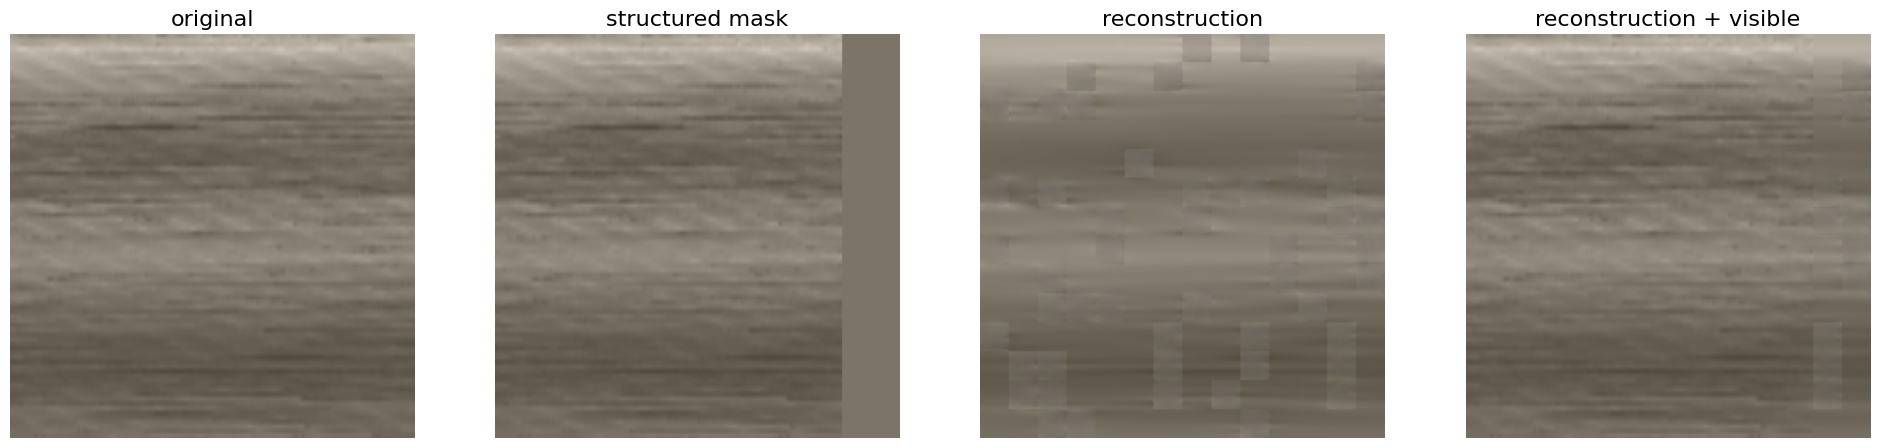

In [16]:
# make random mask reproducible (comment out to make it change)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # usa cuda ou cpu
model = model.to(device)

# Garante reprodutibilidade na máscara aleatória
torch.manual_seed(2)

Igray_resized_3ch_tensor = torch.from_numpy(Igray_resized_3ch).float().to(device)
print('MAE with pixel reconstruction:')
reconstructed_image, imagem_correta = run_one_image_from_aligned_image(Igray_resized_3ch, model)


Algoritmo de reconstrução, mudar o L e H  em def reconstruct_and_evaluate_forecast para
Tabela oficial dos resultados (extraída do artigo)


In [17]:
# 📊 Tabela oficial dos resultados no dataset ETTm1:
# -----------------------------------------------------------
# | L   | H   | MSE ↓   | MAE ↓   |
# |-----|-----|---------|---------|
# | 96  | 96  | 0.234   | 0.368   |
# | 96  | 192 | 0.286   | 0.411   |
# | 96  | 336 | 0.287   | 0.414   |
# | 96  | 720 | 0.365   | 0.470   |
# -----------------------------------------------------------
#

In [18]:
reconstrucao = imagem_correta.numpy() * desvio_padrao/0.4 + mean 
print(reconstrucao)


[[[30.488865  30.488865  30.488865 ]
  [29.703941  29.703941  29.703941 ]
  [28.265518  28.265518  28.265518 ]
  ...
  [33.69995   33.660553  33.865574 ]
  [33.65679   33.631805  33.87303  ]
  [33.69194   33.74897   33.96897  ]]

 [[29.826183  29.826183  29.826183 ]
  [28.887852  28.887852  28.887852 ]
  [27.18079   27.18079   27.18079  ]
  ...
  [34.063637  34.009842  34.181732 ]
  [34.098553  34.036335  34.200867 ]
  [33.9586    33.95814   34.10183  ]]

 [[31.041103  31.041103  31.041103 ]
  [30.384014  30.384014  30.384014 ]
  [29.169456  29.169456  29.169456 ]
  ...
  [34.53936   34.503693  34.677242 ]
  [34.496124  34.479572  34.662624 ]
  [34.453503  34.499363  34.670254 ]]

 ...

 [[11.033521  11.033521  11.033521 ]
  [10.936473  10.936473  10.936473 ]
  [10.810421  10.810421  10.810421 ]
  ...
  [10.992727  11.093447  11.1072645]
  [11.0105    11.073809  11.090273 ]
  [10.984703  11.025236  11.059091 ]]

 [[11.043114  11.043114  11.043114 ]
  [10.908479  10.908479  10.908479 ]


In [19]:
print("im_paste_hw3:", type(reconstrucao), getattr(reconstrucao, "shape", None))
print("original_Inorm:", type(matriz_2d), getattr(matriz_2d, "shape", None))


im_paste_hw3: <class 'numpy.ndarray'> (224, 224, 3)
original_Inorm: <class 'numpy.ndarray'> (88, 750)


In [20]:
def reconstruct_and_evaluate_forecast(
    y_reconstructed, original_Inorm, L=96, H=96, start_idx=None, flatten_order='C'
):
    import numpy as np
    from skimage.transform import resize
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # 1) Reconstrução -> grayscale -> volta ao shape original
    recon_gray = y_reconstructed.mean(axis=-1)
    recon_back = resize(
        recon_gray, original_Inorm.shape, order=1, mode='reflect',
        anti_aliasing=False, preserve_range=True
    )

    P, T = original_Inorm.shape
    recon_2d  = recon_back.reshape(P, T)
    target_2d = original_Inorm.reshape(P, T)

    # 2) Define o corte (mantido)
    if start_idx is not None:
        forecast_start = int(max(0, min(start_idx, T-1)))
        pred_steps = T - forecast_start
    else:
        pred_steps = max(1, min(int(H), T))
        forecast_start = T - pred_steps

    # 3) z = target até forecast_start | recon do forecast_start ao fim (mantido)
    z = target_2d.copy()
    z[:, forecast_start:] = recon_2d[:, forecast_start:]

    # 4) MÉTRICAS APENAS NO ÚLTIMO H DA SÉRIE 1D
    target_1d = target_2d.ravel(order=flatten_order)
    recon_1d  = recon_2d.ravel(order=flatten_order)
    T_series  = target_1d.size
    H_eff     = int(min(max(1, H), T_series))
    eval_start = T_series - H_eff  # ex.: 10000-96 = 9904

    y_t_lastH = target_1d[eval_start:]
    y_p_lastH = recon_1d[eval_start:]

    mse = mean_squared_error(y_t_lastH, y_p_lastH)
    mae = mean_absolute_error(y_t_lastH, y_p_lastH)

    # recorte para plot/uso (mantido)
    recon_forecast = recon_2d[:, forecast_start:]

    print(f"[forecast] T_cols={T}, start_idx={forecast_start}, pred_steps={pred_steps}")
    print(f"[métricas último H] série_total={T_series}, H={H_eff}, eval_start={eval_start} "
          f"-> MSE={mse:.6f} | MAE={mae:.6f}")

    # agora retornamos também os vetores usados no MSE/MAE e o eval_start
    return z, recon_forecast, mse, mae, y_t_lastH, y_p_lastH, eval_start


[forecast] T_cols=750, start_idx=654, pred_steps=96
[métricas último H] série_total=66000, H=96, eval_start=65904 -> MSE=5.631167 | MAE=1.904294


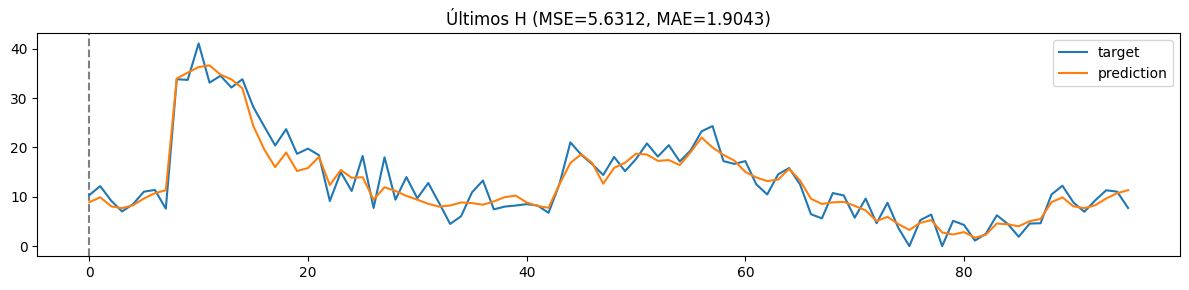

In [21]:
z, recon_fc, mse, mae, y_t_lastH, y_p_lastH, eval_start = reconstruct_and_evaluate_forecast(
    reconstrucao, matriz_2d, H=96, flatten_order='F'
)

# plot rápido só do trecho avaliado:
import numpy as np, matplotlib.pyplot as plt
x = np.arange(len(y_t_lastH))
plt.figure(figsize=(12,3))
plt.axvline(0, ls='--', c='gray')
plt.plot(x, y_t_lastH, label='target')
plt.plot(x, y_p_lastH, label='prediction')
plt.title(f'Últimos H (MSE={mse:.4f}, MAE={mae:.4f})')
plt.legend(); plt.tight_layout(); plt.show()


In [22]:

import numpy as np
from dataclasses import dataclass
from typing import Tuple, Optional, Union
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.transform import resize

ArrayLike = Union[np.ndarray, float]

@dataclass
class ZScoreScaler2D:
    mean: ArrayLike
    std: ArrayLike
    r: float = 0.4  # intensidade de renderização (VisionTS)

def fit_train_scaler_2d(matrix_2d: np.ndarray, n_cols_train: int) -> ZScoreScaler2D:
    """
    Ajusta média/desvio apenas nas colunas de treino (evita vazamento).
    matrix_2d: shape (P, Tcols)
    """
    assert matrix_2d.ndim == 2, "matrix_2d deve ter shape (P, Tcols)"
    assert 1 <= n_cols_train <= matrix_2d.shape[1], "n_cols_train inválido"
    train_part = matrix_2d[:, :n_cols_train]
    mean = float(train_part.mean())
    std  = float(train_part.std() + 1e-8)
    return ZScoreScaler2D(mean=mean, std=std, r=0.4)

def apply_zscore_2d(matrix_2d: np.ndarray, scaler: ZScoreScaler2D) -> np.ndarray:
    return scaler.r * (matrix_2d - scaler.mean) / scaler.std

def invert_zscore_2d(matrix_2d_norm: np.ndarray, scaler: ZScoreScaler2D) -> np.ndarray:
    return (matrix_2d_norm * scaler.std) / scaler.r + scaler.mean

def _flatten_F(matrix_2d: np.ndarray) -> np.ndarray:
    # Reconstrói a série 1D original a partir do reshaping (P, T) via order='F'
    return matrix_2d.ravel(order='F')

def evaluate_last_horizon(y_true_2d: np.ndarray, y_pred_2d: np.ndarray, H: int) -> Tuple[float, float]:
    yt = _flatten_F(y_true_2d)
    yp = _flatten_F(y_pred_2d)
    H_eff = int(max(1, min(H, yt.size)))
    yt_last = yt[-H_eff:]
    yp_last = yp[-H_eff:]
    return mean_absolute_error(yt_last, yp_last), mean_squared_error(yt_last, yp_last)

def reconstruct_and_evaluate_forecast_fixed(
    recon_im: np.ndarray,               # imagem reconstruída (Himg, Wimg, 3) já NA ESCALA ORIGINAL (desnorm.)
    target_matrix_raw: np.ndarray,      # matriz 2D (P, T) NA ESCALA ORIGINAL
    H: int = 96,
    order: str = 'F',
    resize_order: int = 1,
    anti_aliasing: bool = False,
    eval_only_last_cols: Optional[int] = None,  # se você só preencheu as últimas K colunas, informe K para limpar prefixo
    return_both_scales: bool = True,
    scaler: Optional[ZScoreScaler2D] = None
):
    """
    1) Converte a imagem reconstruída -> grayscale -> redimensiona para shape de target (P, T)
    2) Opcionalmente zera o prefixo não previsto (se apenas últimas K colunas foram alteradas)
    3) Calcula MAE/MSE no último H **na escala original** e **na escala normalizada** (se scaler for dado)
    """
    assert target_matrix_raw.ndim == 2, "target_matrix_raw deve ser (P, T)"
    P, T = target_matrix_raw.shape

    # 1) recon -> gray -> back to (P, T)
    if recon_im.ndim == 3 and recon_im.shape[-1] == 3:
        recon_gray = recon_im.mean(axis=-1)
    elif recon_im.ndim == 2:
        recon_gray = recon_im
    else:
        raise ValueError("recon_im deve ser (H, W) ou (H, W, 3)")

    recon_back = resize(recon_gray, (P, T), order=resize_order, mode='reflect',
                        anti_aliasing=anti_aliasing, preserve_range=True)
    recon_2d = recon_back.reshape(P, T)

    # 2) Se só previmos as últimas K colunas, mantemos prefixo do alvo para não poluir métricas
    if isinstance(eval_only_last_cols, int) and eval_only_last_cols > 0:
        k = min(eval_only_last_cols, T)
        pred = target_matrix_raw.copy()
        pred[:, -k:] = recon_2d[:, -k:]
    else:
        pred = recon_2d

    # 3) Métricas na escala original
    mae_raw, mse_raw = evaluate_last_horizon(target_matrix_raw, pred, H)

    result = {
        "mae_raw": float(mae_raw),
        "mse_raw": float(mse_raw),
    }

    # 4) Métricas na escala normalizada (se fornecido scaler)
    if return_both_scales and scaler is not None:
        y_true_n = apply_zscore_2d(target_matrix_raw, scaler)
        y_pred_n = apply_zscore_2d(pred, scaler)
        mae_n, mse_n = evaluate_last_horizon(y_true_n, y_pred_n, H)
        result.update({
            "mae_norm": float(mae_n),
            "mse_norm": float(mse_n),
        })

    return pred, result


In [23]:
# === Article-style MAE/MSE (LTSF) – drop-in ===
import math
from typing import Tuple, Dict
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def _flatten_F(M: np.ndarray) -> np.ndarray:
    return M.ravel(order="F")

def _eval_last_H(y_true_2d: np.ndarray, y_pred_2d: np.ndarray, H: int) -> Tuple[float, float]:
    yt = _flatten_F(y_true_2d); yp = _flatten_F(y_pred_2d)
    H_eff = int(max(1, min(H, yt.size)))
    return float(mean_absolute_error(yt[-H_eff:], yp[-H_eff:])), float(mean_squared_error(yt[-H_eff:], yp[-H_eff:]))

def fit_zscore_on_train(M_raw: np.ndarray, n_cols_train: int) -> Tuple[float, float]:
    if M_raw.ndim != 2: raise ValueError("M_raw must be 2D (P,T)")
    if not (1 <= n_cols_train <= M_raw.shape[1]): raise ValueError("n_cols_train out of range")
    train = M_raw[:, :n_cols_train]
    mu = float(train.mean()); sd = float(train.std() + 1e-8)
    return mu, sd

def _resize_nn(image: np.ndarray, out_shape: Tuple[int, int]) -> np.ndarray:
    in_h, in_w = image.shape; out_h, out_w = out_shape
    row_idx = (np.linspace(0, in_h - 1, out_h)).round().astype(int)
    col_idx = (np.linspace(0, in_w - 1, out_w)).round().astype(int)
    return image[row_idx][:, col_idx]

def _to_matrix_like(arr: np.ndarray, P: int, T: int) -> np.ndarray:
    a = np.asarray(arr)
    if a.ndim == 2:
        if a.shape == (P, T): return a
        return _resize_nn(a, (P, T)).astype(float)
    if a.ndim == 3 and a.shape[-1] == 3:
        gray = a.mean(axis=-1)
        return _resize_nn(gray, (P, T)).astype(float)
    raise ValueError("Use (P,T) ou imagem (H,W)/(H,W,3).")

def compute_article_metrics(
    matriz_2d: np.ndarray,
    reconstrucao: np.ndarray,
    H: int,
    recon_mode: str = "raw",
    r: float = 0.4,
) -> Tuple[np.ndarray, Dict[str, float]]:
    """
    Calcula MAE/MSE no estilo LTSF:
      - normalização: z-score ajustado no TREINO (prefixo)
      - retorna métricas normalizadas e brutas (raw)
    recon_mode: 'raw' (recon já na escala original),
                'rendered' (r*(x-mu)/sd),
                'normalized' ((x-mu)/sd)
    """
    if matriz_2d.ndim != 2: raise ValueError("matriz_2d must be 2D (P,T)")
    P, T = matriz_2d.shape
    K = int(math.ceil(H / max(1, P))); K = max(1, min(K, T))
    n_cols_train = max(1, T - K)
    mu, sd = fit_zscore_on_train(matriz_2d, n_cols_train=n_cols_train)

    recon_PT = _to_matrix_like(reconstrucao, P, T)
    if recon_mode == "raw":
        recon_raw = recon_PT
    elif recon_mode == "rendered":
        if r <= 0: raise ValueError("r must be > 0 for rendered mode")
        recon_raw = (recon_PT * sd) / r + mu
    elif recon_mode == "normalized":
        recon_raw = (recon_PT * sd) + mu
    else:
        raise ValueError("recon_mode must be 'raw', 'rendered', or 'normalized'")

    pred_raw = np.array(matriz_2d, copy=True)
    pred_raw[:, -K:] = recon_raw[:, -K:]

    mae_raw, mse_raw = _eval_last_H(matriz_2d, pred_raw, H=H)
    y_true_n = (matriz_2d - mu) / sd
    y_pred_n = (pred_raw   - mu) / sd
    mae_norm, mse_norm = _eval_last_H(y_true_n, y_pred_n, H=H)

    return pred_raw, {"mae_norm": mae_norm, "mse_norm": mse_norm, "mae_raw": mae_raw, "mse_raw": mse_raw}


In [24]:
# matriz_2d: np.ndarray (P,T) em escala bruta
# reconstrucao: previsão (P,T) em escala bruta (ou imagem)
pred_raw, res = compute_article_metrics(matriz_2d, reconstrucao, H=96, recon_mode="raw")
print(res)  # {'mae_norm','mse_norm','mae_raw','mse_raw'}


{'mae_norm': 0.22339737495374665, 'mse_norm': 0.07847408298891113, 'mae_raw': 1.9513576067984106, 'mse_raw': 5.987476883156853}


✅ ResNet carregada com pesos do ImageNet e saída = 96
Previsão gerada (96 pontos):
[-0.4909653  -0.02255693 -0.04359495  0.3666734   0.08703931  0.11271604
 -0.2361402   0.20845923  0.15823235  0.2741139 ]


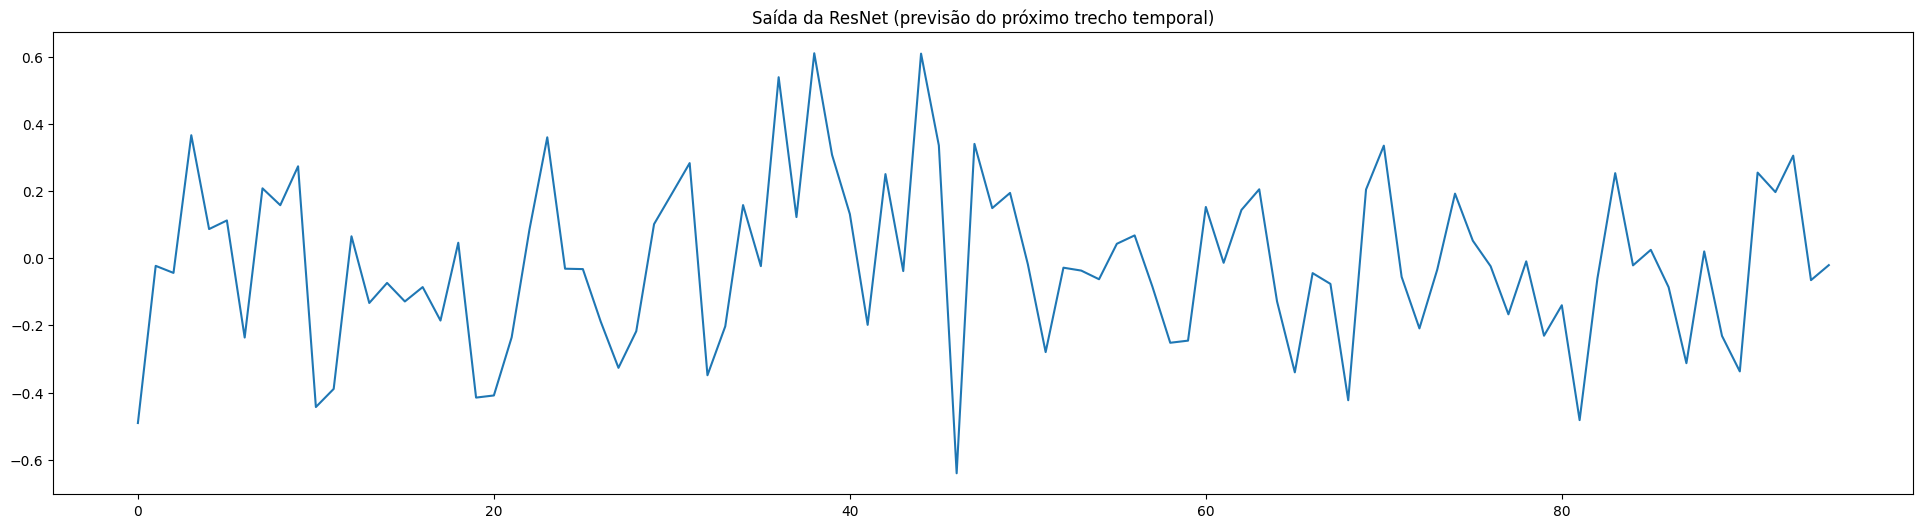

In [25]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Carrega a ResNet pré-treinada no ImageNet ===
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Congela os pesos base
for param in resnet.parameters():
    param.requires_grad = False

# === 2. Substitui a camada final por regressão temporal ===
# Suponha que queremos prever H=96 pontos futuros (pode ajustar)
H = 96
resnet.fc = nn.Linear(resnet.fc.in_features, H)

model = resnet.to(device)
print("✅ ResNet carregada com pesos do ImageNet e saída =", H)

# === 3. Função de previsão ===
def predict_next_block(Igray_resized_3ch, model):
    """
    Usa a ResNet para extrair features da imagem da série temporal
    e prever o próximo bloco temporal (H pontos).
    """
    from torchvision import transforms
    from skimage.transform import resize

    # Redimensionar para 224x224 e normalizar como ImageNet
    img = resize(Igray_resized_3ch, (224, 224), order=1, mode='reflect', anti_aliasing=False)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    x = transform(img).unsqueeze(0).to(device)

    # ✅ converte para float32
    x = x.float()

    # Forward
    with torch.no_grad():
        y_pred = model(x).cpu().numpy().flatten()

    return y_pred


# === 4. Exemplo de uso ===
# Faz uma previsão para a sua imagem 3 canais já alinhada
y_pred = predict_next_block(Igray_resized_3ch, model)

print(f"Previsão gerada ({len(y_pred)} pontos):")
print(y_pred[:10])
plt.plot(y_pred)
plt.title("Saída da ResNet (previsão do próximo trecho temporal)")
plt.show()



ResNet18
→ y_true range: [0.000, 41.083]
→ y_pred range: [3.810, 24.454]


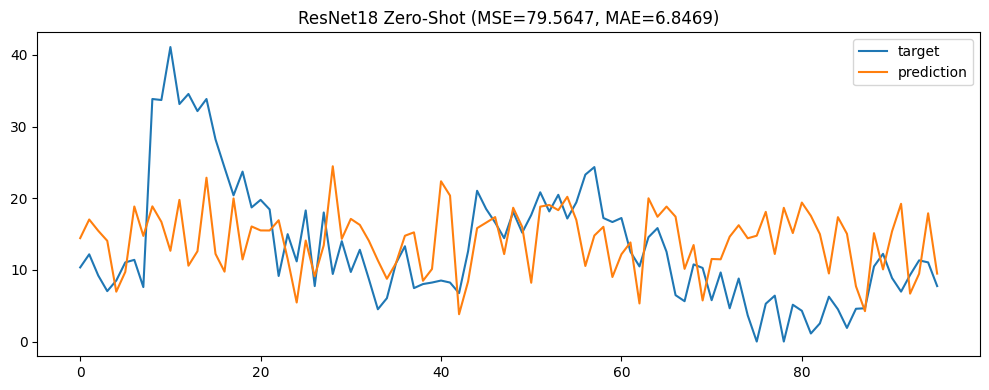


ResNet50
→ y_true range: [0.000, 41.083]
→ y_pred range: [6.595, 20.411]


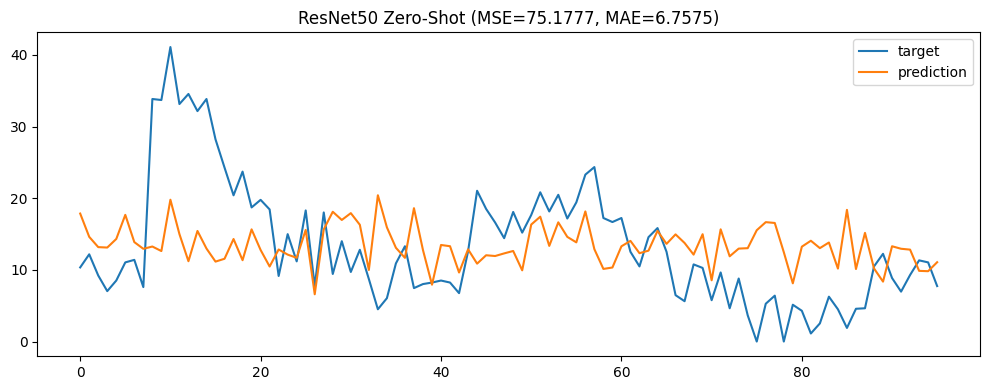


ResNet101
→ y_true range: [0.000, 41.083]
→ y_pred range: [3.208, 22.387]


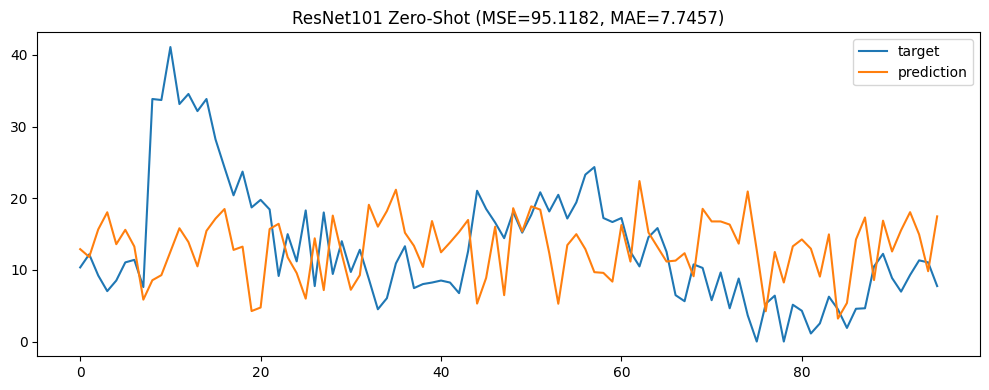


=== Comparação Final ===
ResNet18   → MSE=79.5647 | MAE=6.8469
ResNet50   → MSE=75.1777 | MAE=6.7575
ResNet101  → MSE=95.1182 | MAE=7.7457


In [28]:
# ==============================================
# 🔮 Zero-Shot ResNet Forecasting (ImageNet) — Corrigido
# ==============================================
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Função para carregar ResNet com pesos do ImageNet ===
def load_resnet(depth: str, out_dim: int):
    weight_enums = {
        "resnet18":  models.ResNet18_Weights.IMAGENET1K_V1,
        "resnet34":  models.ResNet34_Weights.IMAGENET1K_V1,
        "resnet50":  models.ResNet50_Weights.IMAGENET1K_V1,
        "resnet101": models.ResNet101_Weights.IMAGENET1K_V1,
        "resnet152": models.ResNet152_Weights.IMAGENET1K_V1,
    }

    w = weight_enums[depth]
    net = getattr(models, depth)(weights=w)

    # congela o backbone
    for p in net.parameters():
        p.requires_grad = False

    # substitui a camada final (fc) para previsão de H pontos
    net.fc = nn.Linear(net.fc.in_features, out_dim)
    return net.to(device).eval()

# === 2. Função de previsão ===
def predict_next_block(Igray_resized_3ch, model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # garante que a imagem esteja entre 0–1 antes de normalizar
    Igray_resized_3ch = Igray_resized_3ch.astype(np.float32)
    if Igray_resized_3ch.max() > 1.0:
        Igray_resized_3ch = Igray_resized_3ch / Igray_resized_3ch.max()

    # Redimensiona para 224x224 (como ImageNet)
    img = resize(Igray_resized_3ch, (224, 224), order=1, mode='reflect', anti_aliasing=False)
    x = transform(img).unsqueeze(0).to(device).float()

    with torch.no_grad():
        y_pred = model(x).cpu().numpy().flatten()

    return y_pred

# === 3. Função para avaliar previsão ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae

# === 4. Normalização automática ===
def normalize_series(y):
    """Retorna série normalizada, média e desvio padrão para desnormalização posterior."""
    y = np.array(y)
    mean, std = np.mean(y), np.std(y)
    y_norm = (y - mean) / (std + 1e-8)
    return y_norm, mean, std

def denormalize_series(y_norm, mean, std):
    return y_norm * std + mean

# === 5. Rodar previsões ===
H = 96  # horizonte de previsão (96 passos futuros)
nets = [
    load_resnet("resnet18",  H),
    load_resnet("resnet50",  H),
    load_resnet("resnet101", H)
]

model_names = ["ResNet18", "ResNet50", "ResNet101"]
predictions = []
metrics = []

# Normaliza a série de referência
y_true_norm, y_mean, y_std = normalize_series(y_t_lastH)

for name, net in zip(model_names, nets):
    # previsão
    y_pred_norm = predict_next_block(Igray_resized_3ch, net)

    # desnormaliza a previsão para comparar no domínio original
    y_pred = denormalize_series(y_pred_norm, y_mean, y_std)

    # calcula métricas
    mse, mae = evaluate_forecast(y_t_lastH, y_pred)
    metrics.append((mse, mae))
    predictions.append(y_pred)

    # debug de faixas
    print(f"\n{name}")
    print(f"→ y_true range: [{y_t_lastH.min():.3f}, {y_t_lastH.max():.3f}]")
    print(f"→ y_pred range: [{y_pred.min():.3f}, {y_pred.max():.3f}]")

    # gráfico
    plt.figure(figsize=(10,4))
    plt.plot(y_t_lastH, label="target")
    plt.plot(y_pred, label="prediction")
    plt.title(f"{name} Zero-Shot (MSE={mse:.4f}, MAE={mae:.4f})")
    plt.legend(); plt.tight_layout()
    plt.show()

# === 6. Comparar resultados ===
print("\n=== Comparação Final ===")
for name, (mse, mae) in zip(model_names, metrics):
    print(f"{name:10s} → MSE={mse:.4f} | MAE={mae:.4f}")


🖥️ Dispositivo: cpu
✔️ Série carregada: (69680,)
✅ Modelo configurado para previsão de 96 passos.
🌀 Epoch 1/10 - Loss médio: 142.950477
🌀 Epoch 2/10 - Loss médio: 29.229157
🌀 Epoch 3/10 - Loss médio: 20.519903
🌀 Epoch 4/10 - Loss médio: 17.691710
🌀 Epoch 5/10 - Loss médio: 13.402724
🌀 Epoch 6/10 - Loss médio: 9.484278
🌀 Epoch 7/10 - Loss médio: 9.643677
🌀 Epoch 8/10 - Loss médio: 7.874438
🌀 Epoch 9/10 - Loss médio: 9.029361
🌀 Epoch 10/10 - Loss médio: 6.852955

📊 Resultado final — MSE=65.6234 | MAE=6.6105


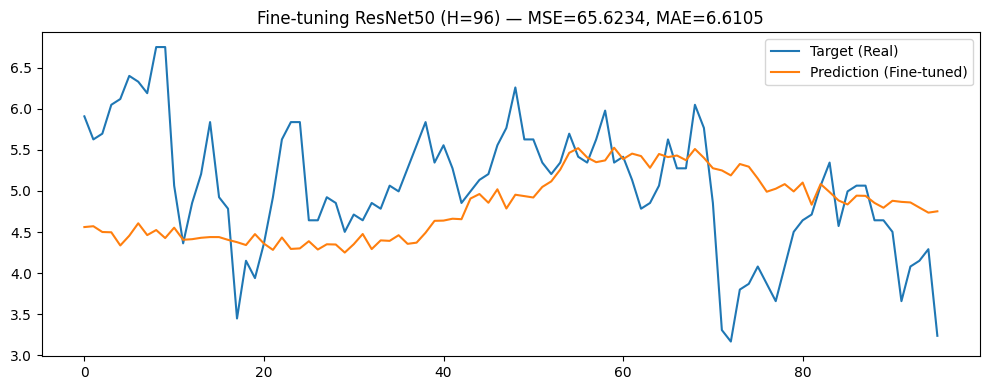

In [29]:
# ===========================================
# 🔧 FINE-TUNING LEVE - RESNET (ETTm1)
# ===========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------------------------------------
# 1️⃣ Configuração e Dataset
# ----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Dispositivo:", device)

# === Parâmetros ===
H = 96   # horizonte de previsão
L = 96   # janela de entrada
BATCH_SIZE = 8
EPOCHS = 10
LR = 1e-4

# === Carrega dataset ETTm1 ===
df = pd.read_csv("https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTm1.csv")
serie = df["OT"].values.astype(np.float32)
print("✔️ Série carregada:", serie.shape)

# ----------------------------------------------------------
# 2️⃣ Classe de Dataset: converte janelas temporais em imagens (VisionTS)
# ----------------------------------------------------------
class TimeSeriesImageDataset(Dataset):
    def __init__(self, serie, L=96, H=96, step=1):
        self.serie = serie
        self.L = L
        self.H = H
        self.step = step
        self.mean = np.mean(serie)
        self.std = np.std(serie)
        self.r = 0.4
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ])
        self.samples = []
        for i in range(0, len(serie) - L - H, step):
            self.samples.append(i)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        i = self.samples[idx]
        x = self.serie[i:i+self.L]
        y = self.serie[i+self.L:i+self.L+self.H]

        # --- transforma janela em imagem VisionTS ---
        P =96  # periodicidade aproximada
        Lc = (len(x)//P)*P
        matriz_2d = x[:Lc].reshape(P, -1)
        mean, std = self.mean, self.std
        Inorm = self.r * (matriz_2d - mean)/std
        Igray = np.stack([Inorm]*3, axis=-1)
        Igray_resized = resize(Igray, (224,224), order=1, mode='reflect', anti_aliasing=False)

        x_tensor = self.transform(Igray_resized).float()  # [3,224,224]
        y_tensor = torch.tensor(y, dtype=torch.float32)
        return x_tensor, y_tensor

# === Cria dataloaders (pequenos para CPU também rodar) ===
train_ds = TimeSeriesImageDataset(serie[:60000], L=L, H=H, step=96)
test_ds  = TimeSeriesImageDataset(serie[60000:], L=L, H=H, step=96)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=1, shuffle=False)

# ----------------------------------------------------------
# 3️⃣ Modelo - ResNet pré-treinada + ajuste final
# ----------------------------------------------------------
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# descongela apenas as últimas camadas (layer4 e fc)
for name, param in resnet.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# substitui saída para previsão de H pontos
resnet.fc = nn.Linear(resnet.fc.in_features, H)
resnet = resnet.to(device)
print("✅ Modelo configurado para previsão de", H, "passos.")

# ----------------------------------------------------------
# 4️⃣ Treinamento leve
# ----------------------------------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=LR)

for epoch in range(EPOCHS):
    resnet.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = resnet(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"🌀 Epoch {epoch+1}/{EPOCHS} - Loss médio: {total_loss/len(train_dl):.6f}")

# ----------------------------------------------------------
# 5️⃣ Avaliação no conjunto de teste
# ----------------------------------------------------------
resnet.eval()
y_true_all, y_pred_all = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        pred = resnet(xb).cpu().numpy().flatten()
        y_true_all.append(yb.numpy().flatten())
        y_pred_all.append(pred)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

mse = mean_squared_error(y_true_all, y_pred_all)
mae = mean_absolute_error(y_true_all, y_pred_all)
print(f"\n📊 Resultado final — MSE={mse:.4f} | MAE={mae:.4f}")

# ----------------------------------------------------------
# 6️⃣ Visualização de uma previsão
# ----------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(y_true_all[:H], label="Target (Real)")
plt.plot(y_pred_all[:H], label="Prediction (Fine-tuned)")
plt.title(f"Fine-tuning ResNet50 (H={H}) — MSE={mse:.4f}, MAE={mae:.4f}")
plt.legend()
plt.tight_layout()
plt.show()


📈 Previsão gerada para o seu Igray_resized_3ch (96 pontos):
[18.922825 19.212648 18.914608 18.80525  18.670671 18.811806 18.727755
 18.954607 18.949768 18.679138]


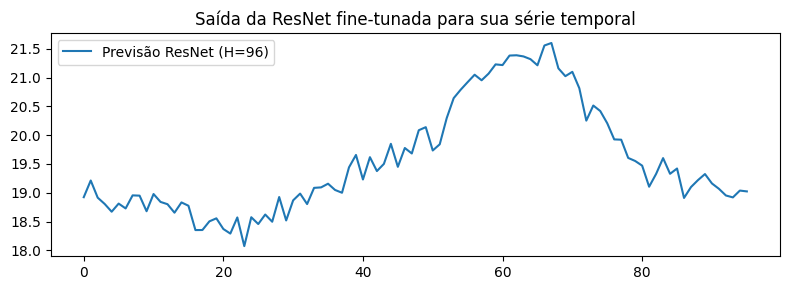

In [30]:
# ===========================================
# 7️⃣ Fazer previsão com seu Igray_resized_3ch já existente
# ===========================================
from torchvision import transforms
from skimage.transform import resize

# --- 1. Se sua imagem tiver só 1 canal, converta para 3 ---
if Igray_resized.ndim == 2:  # (H, W)
    Igray_resized_3ch = np.stack([Igray_resized]*3, axis=-1)
else:
    Igray_resized_3ch = Igray_resized

# --- 2. Redimensiona e normaliza como o modelo espera (ImageNet) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 3. Redimensiona para 224x224 ---
img_resized = resize(Igray_resized_3ch, (224,224), order=1, mode='reflect', anti_aliasing=False)
x = transform(img_resized).unsqueeze(0).to(device).float()

# --- 4. Faz a previsão ---
resnet.eval()
with torch.no_grad():
    y_pred = resnet(x).cpu().numpy().flatten()

# --- 5. Exibe ---
print(f"📈 Previsão gerada para o seu Igray_resized_3ch ({len(y_pred)} pontos):")
print(y_pred[:10])

plt.figure(figsize=(8,3))
plt.plot(y_pred, label='Previsão ResNet (H=96)')
plt.title("Saída da ResNet fine-tunada para sua série temporal")
plt.legend()
plt.tight_layout()
plt.show()


Zero-shot → MSE=247.6539 | MAE=13.2728


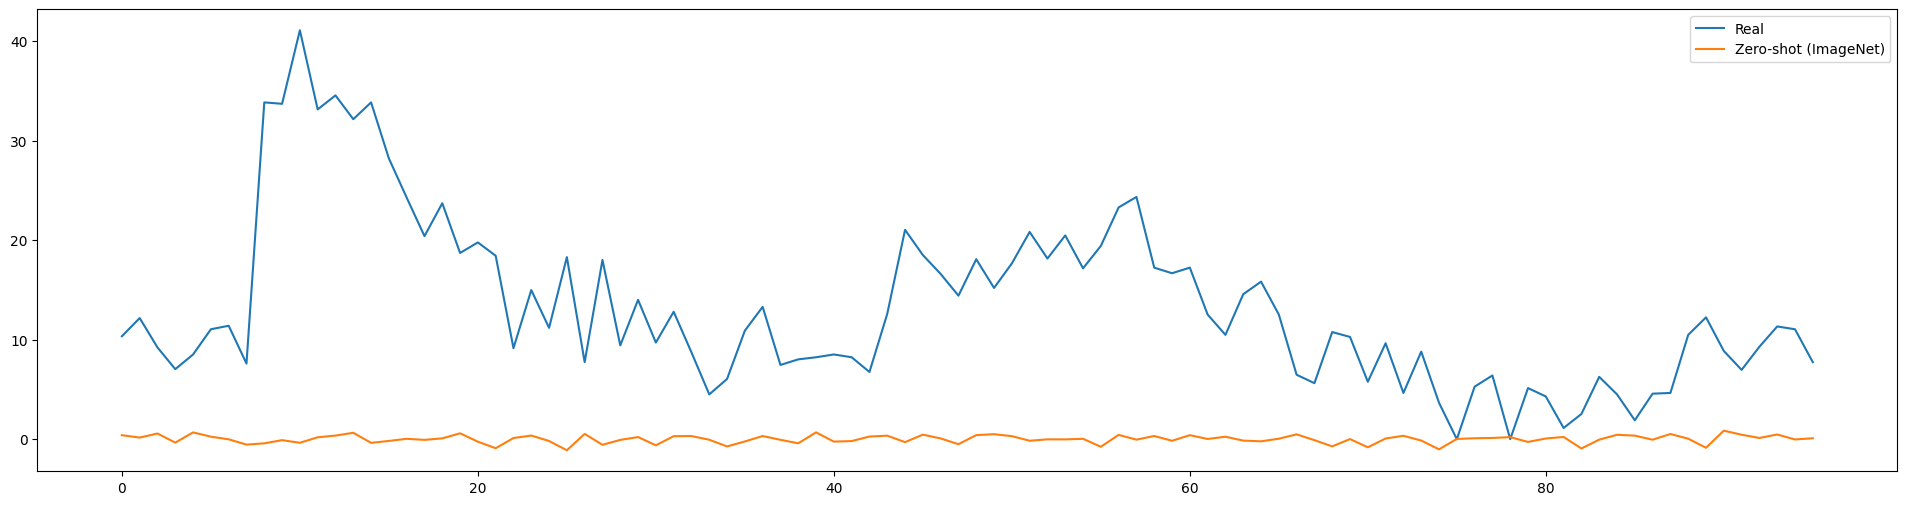

In [31]:
import torch, torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_resnet(depth: str, out_dim: int):
    weights = {
        "resnet18":  models.ResNet18_Weights.IMAGENET1K_V1,
        "resnet50":  models.ResNet50_Weights.IMAGENET1K_V1,
        "resnet101": models.ResNet101_Weights.IMAGENET1K_V1,
    }
    w = weights[depth]
    net = getattr(models, depth)(weights=w)
    for p in net.parameters():  # congela backbone
        p.requires_grad = False
    net.fc = nn.Linear(net.fc.in_features, out_dim)
    return net.to(device).eval()

def predict(img3ch, model, imagenet_norm=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])
    img = resize(img3ch, (224,224), order=1, mode='reflect', anti_aliasing=False)
    x = transform(img).unsqueeze(0).to(device).float()
    with torch.no_grad():
        return model(x).cpu().numpy().flatten()

def evaluate(y_true, y_pred):
    return mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred)

H = 96
resnet50 = load_resnet("resnet50", H)
y_pred1 = predict(Igray_resized_3ch, resnet50)
mse1, mae1 = evaluate(y_t_lastH, y_pred1)
print(f"Zero-shot → MSE={mse1:.4f} | MAE={mae1:.4f}")

plt.plot(y_t_lastH, label="Real")
plt.plot(y_pred1, label="Zero-shot (ImageNet)")
plt.legend(); plt.show()


Z-score → MSE=247.7193 | MAE=13.2805


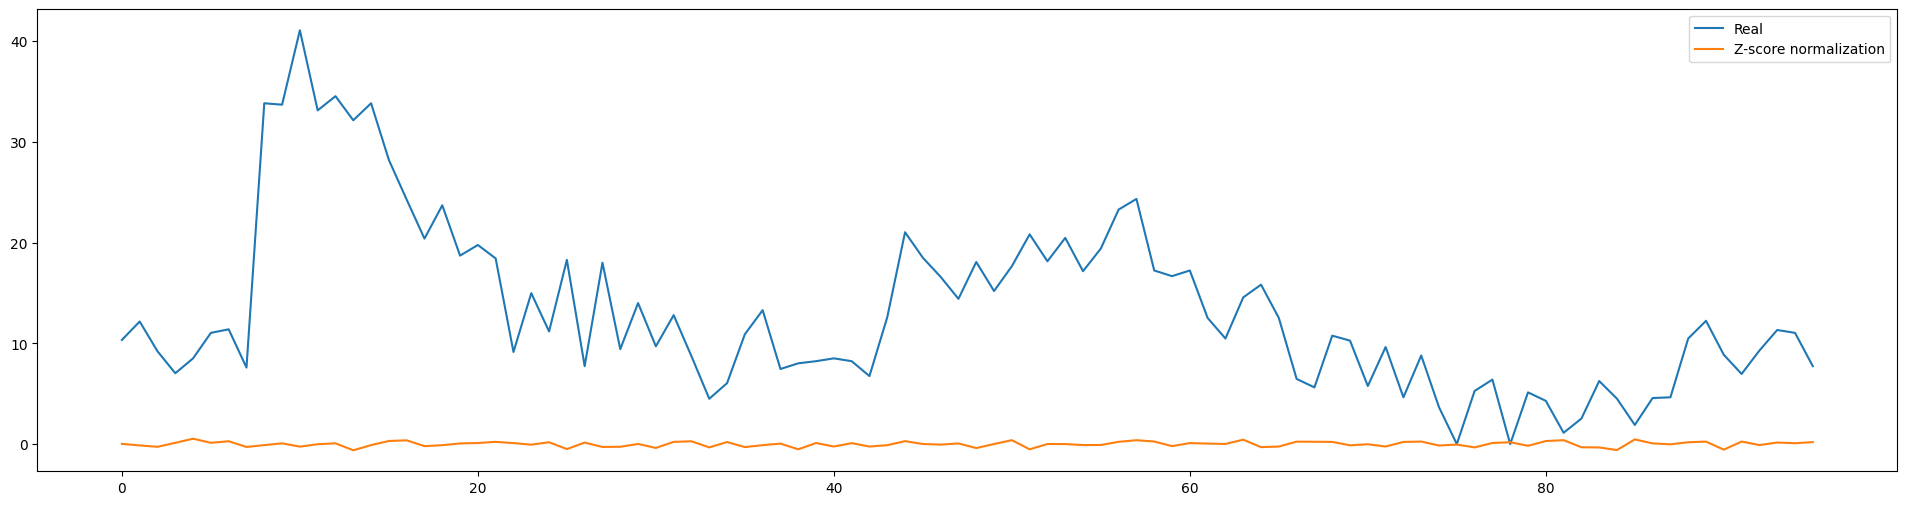

In [32]:
def predict_zscore(img3ch, model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0,0.0,0.0],
                             std=[1.0,1.0,1.0])
    ])
    img = resize(img3ch, (224,224), order=1, mode='reflect', anti_aliasing=False)
    x = transform(img).unsqueeze(0).to(device).float()
    with torch.no_grad():
        return model(x).cpu().numpy().flatten()

resnet50_z = load_resnet("resnet50", H)
y_pred2 = predict_zscore(Igray_resized_3ch, resnet50_z)
mse2, mae2 = evaluate(y_t_lastH, y_pred2)
print(f"Z-score → MSE={mse2:.4f} | MAE={mae2:.4f}")

plt.plot(y_t_lastH, label="Real")
plt.plot(y_pred2, label="Z-score normalization")
plt.legend(); plt.show()


In [ ]:
nets = [
    load_resnet("resnet18",  H),
    load_resnet("resnet50",  H),
    load_resnet("resnet101", H)
]

preds = [predict(Igray_resized_3ch, m) for m in nets]
y_pred3 = np.mean(preds, axis=0)
mse3, mae3 = evaluate(y_t_lastH, y_pred3)
print(f"Ensemble → MSE={mse3:.4f} | MAE={mae3:.4f}")

plt.plot(y_t_lastH, label="Real")
plt.plot(y_pred3, label="Ensemble (18+50+101)")
plt.legend(); plt.show()


In [ ]:
resnet_ft = load_resnet("resnet50", H)

# descongela apenas a camada fc
for n,p in resnet_ft.named_parameters():
    p.requires_grad = ("fc" in n)

optimizer = torch.optim.Adam(resnet_ft.fc.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# prepara a entrada
transform_ft = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0,0.0,0.0],
                         std=[1.0,1.0,1.0])
])
img_ft = resize(Igray_resized_3ch, (224,224), order=1, mode='reflect', anti_aliasing=False)
x_ft = transform_ft(img_ft).unsqueeze(0).to(device).float()
y_ft = torch.tensor(y_t_lastH, dtype=torch.float32).unsqueeze(0).to(device)

resnet_ft.train()
for epoch in range(3):  # fine-tuning leve
    optimizer.zero_grad()
    pred = resnet_ft(x_ft)
    loss = criterion(pred, y_ft)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: loss={loss.item():.6f}")

# avaliação
resnet_ft.eval()
y_pred4 = resnet_ft(x_ft).cpu().detach().numpy().flatten()
mse4, mae4 = evaluate(y_t_lastH, y_pred4)
print(f"Fine-tuning leve → MSE={mse4:.4f} | MAE={mae4:.4f}")

plt.plot(y_t_lastH, label="Real")
plt.plot(y_pred4, label="Fine-tuning leve (fc)")
plt.legend(); plt.show()
